In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../utils')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataset import RigNetDataset, collate_fn, FILE_PATHS, POS_ATTN_AVG
from models import JointNet
from visualization_utils import visualize_mesh_graph, visualize_attention_heatmap


import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_recall_curve

In [13]:
dataset = RigNetDataset(FILE_PATHS['val'], num_samples=4, seed=42)
dl = DataLoader(
    dataset=dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

In [14]:
model = JointNet()
device = 'cpu'
model.to(device)

JointNet(
  (feature_extractor): JointFeatureNet(
    (disp_head): JointDisplacementModule(
      (model): GMEdgeNet(
        (conv1): GMEdgeConv(
          (mlp_topo): Sequential(
            (0): Linear(in_features=6, out_features=64, bias=True)
            (1): ReLU()
            (2): Linear(in_features=64, out_features=64, bias=True)
            (3): ReLU()
          )
          (mlp_geo): Sequential(
            (0): Linear(in_features=6, out_features=64, bias=True)
            (1): ReLU()
            (2): Linear(in_features=64, out_features=64, bias=True)
            (3): ReLU()
          )
          (mlp_fuse): Sequential(
            (0): Linear(in_features=128, out_features=64, bias=True)
            (1): ReLU()
          )
        )
        (conv2): GMEdgeConv(
          (mlp_topo): Sequential(
            (0): Linear(in_features=128, out_features=256, bias=True)
            (1): ReLU()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): ReL

### Attention Module

In [15]:
POS_ATTN_AVG, (1 - POS_ATTN_AVG) / POS_ATTN_AVG

(0.2964, 2.3738191632928474)

In [23]:
epochs = 100
lr = 1e-4
wd = 1e-6
optimizer = torch.optim.AdamW(model.attn_head_parameters(), lr=lr, weight_decay=wd)
pos_cls_weight = torch.tensor((1 - POS_ATTN_AVG) / POS_ATTN_AVG)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_cls_weight)

Epoch 1/100: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


[Epoch 1] loss=0.9610


Epoch 2/100: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


[Epoch 2] loss=0.9594


Epoch 3/100: 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


[Epoch 3] loss=0.9579


Epoch 4/100: 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


[Epoch 4] loss=0.9565


Epoch 5/100: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


[Epoch 5] loss=0.9549


Epoch 6/100: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


[Epoch 6] loss=0.9533


Epoch 7/100: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


[Epoch 7] loss=0.9515


Epoch 8/100: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


[Epoch 8] loss=0.9496


Epoch 9/100: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


[Epoch 9] loss=0.9474


Epoch 10/100: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


[Epoch 10] loss=0.9450


Epoch 11/100: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


[Epoch 11] loss=0.9422


Epoch 12/100: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


[Epoch 12] loss=0.9391


Epoch 13/100: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


[Epoch 13] loss=0.9356


Epoch 14/100: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


[Epoch 14] loss=0.9316


Epoch 15/100: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


[Epoch 15] loss=0.9270


Epoch 16/100: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


[Epoch 16] loss=0.9216


Epoch 17/100: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


[Epoch 17] loss=0.9153


Epoch 18/100: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


[Epoch 18] loss=0.9080


Epoch 19/100: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


[Epoch 19] loss=0.8995


Epoch 20/100: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


[Epoch 20] loss=0.8901


Epoch 21/100: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


[Epoch 21] loss=0.8799


Epoch 22/100: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


[Epoch 22] loss=0.8687


Epoch 23/100: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


[Epoch 23] loss=0.8565


Epoch 24/100: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


[Epoch 24] loss=0.8436


Epoch 25/100: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


[Epoch 25] loss=0.8308


Epoch 26/100: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


[Epoch 26] loss=0.8186


Epoch 27/100: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


[Epoch 27] loss=0.8074


Epoch 28/100: 100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


[Epoch 28] loss=0.7975


Epoch 29/100: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


[Epoch 29] loss=0.7899


Epoch 30/100: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


[Epoch 30] loss=0.7844


Epoch 31/100: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


[Epoch 31] loss=0.7803


Epoch 32/100: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


[Epoch 32] loss=0.7768


Epoch 33/100: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


[Epoch 33] loss=0.7731


Epoch 34/100: 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


[Epoch 34] loss=0.7689


Epoch 35/100: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


[Epoch 35] loss=0.7647


Epoch 36/100: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


[Epoch 36] loss=0.7610


Epoch 37/100: 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


[Epoch 37] loss=0.7581


Epoch 38/100: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


[Epoch 38] loss=0.7558


Epoch 39/100: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


[Epoch 39] loss=0.7539


Epoch 40/100: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


[Epoch 40] loss=0.7521


Epoch 41/100: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


[Epoch 41] loss=0.7502


Epoch 42/100: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


[Epoch 42] loss=0.7483


Epoch 43/100: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


[Epoch 43] loss=0.7465


Epoch 44/100: 100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


[Epoch 44] loss=0.7448


Epoch 45/100: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


[Epoch 45] loss=0.7432


Epoch 46/100: 100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


[Epoch 46] loss=0.7419


Epoch 47/100: 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


[Epoch 47] loss=0.7406


Epoch 48/100: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


[Epoch 48] loss=0.7395


Epoch 49/100: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


[Epoch 49] loss=0.7383


Epoch 50/100: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


[Epoch 50] loss=0.7370


Epoch 51/100: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


[Epoch 51] loss=0.7358


Epoch 52/100: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


[Epoch 52] loss=0.7346


Epoch 53/100: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


[Epoch 53] loss=0.7335


Epoch 54/100: 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


[Epoch 54] loss=0.7322


Epoch 55/100: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[Epoch 55] loss=0.7309


Epoch 56/100: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


[Epoch 56] loss=0.7297


Epoch 57/100: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


[Epoch 57] loss=0.7285


Epoch 58/100: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


[Epoch 58] loss=0.7270


Epoch 59/100: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


[Epoch 59] loss=0.7255


Epoch 60/100: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


[Epoch 60] loss=0.7239


Epoch 61/100: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


[Epoch 61] loss=0.7223


Epoch 62/100: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


[Epoch 62] loss=0.7207


Epoch 63/100: 100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


[Epoch 63] loss=0.7190


Epoch 64/100: 100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


[Epoch 64] loss=0.7174


Epoch 65/100: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


[Epoch 65] loss=0.7163


Epoch 66/100: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


[Epoch 66] loss=0.7156


Epoch 67/100: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


[Epoch 67] loss=0.7150


Epoch 68/100: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


[Epoch 68] loss=0.7141


Epoch 69/100: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


[Epoch 69] loss=0.7132


Epoch 70/100: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


[Epoch 70] loss=0.7124


Epoch 71/100: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


[Epoch 71] loss=0.7116


Epoch 72/100: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


[Epoch 72] loss=0.7108


Epoch 73/100: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


[Epoch 73] loss=0.7100


Epoch 74/100: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


[Epoch 74] loss=0.7091


Epoch 75/100: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


[Epoch 75] loss=0.7082


Epoch 76/100: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


[Epoch 76] loss=0.7073


Epoch 77/100: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


[Epoch 77] loss=0.7063


Epoch 78/100: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


[Epoch 78] loss=0.7054


Epoch 79/100: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


[Epoch 79] loss=0.7044


Epoch 80/100: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


[Epoch 80] loss=0.7034


Epoch 81/100: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


[Epoch 81] loss=0.7024


Epoch 82/100: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


[Epoch 82] loss=0.7014


Epoch 83/100: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


[Epoch 83] loss=0.7003


Epoch 84/100: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


[Epoch 84] loss=0.6992


Epoch 85/100: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


[Epoch 85] loss=0.6980


Epoch 86/100: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


[Epoch 86] loss=0.6968


Epoch 87/100: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


[Epoch 87] loss=0.6956


Epoch 88/100: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


[Epoch 88] loss=0.6943


Epoch 89/100: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


[Epoch 89] loss=0.6930


Epoch 90/100: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


[Epoch 90] loss=0.6916


Epoch 91/100: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


[Epoch 91] loss=0.6903


Epoch 92/100: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


[Epoch 92] loss=0.6888


Epoch 93/100: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


[Epoch 93] loss=0.6874


Epoch 94/100: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


[Epoch 94] loss=0.6859


Epoch 95/100: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


[Epoch 95] loss=0.6844


Epoch 96/100: 100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


[Epoch 96] loss=0.6828


Epoch 97/100: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


[Epoch 97] loss=0.6811


Epoch 98/100: 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


[Epoch 98] loss=0.6795


Epoch 99/100: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


[Epoch 99] loss=0.6778


Epoch 100/100: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]

[Epoch 100] loss=0.6761


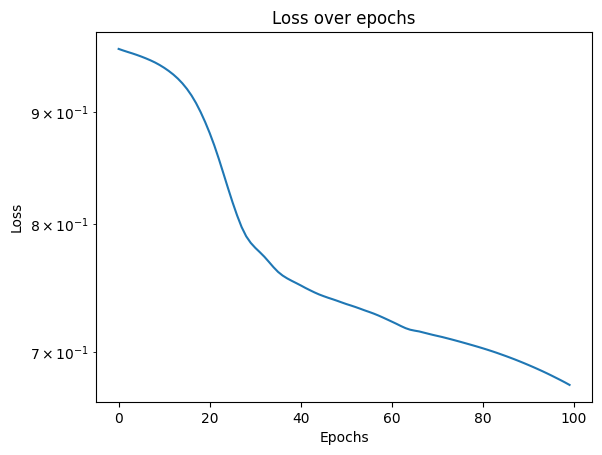

In [24]:
loss_over_epochs = []
for epoch in range(1, epochs+1):
    model.train()
    epoch_loss = 0.0
    total_batches = 0
    for batch in tqdm(dl, desc=f"Epoch {epoch}/{epochs}"):

        batch_size = batch['vertices_per_graph'].size(0)

        logits = model.attn_head_forward(batch).squeeze()
        loss = criterion(logits, batch['attn_mask'])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        total_batches += 1
    epoch_loss /= total_batches

    loss_over_epochs.append(epoch_loss)
    print(f"[Epoch {epoch}] loss={epoch_loss:.4f}")


plt.figure()
plt.semilogy(loss_over_epochs)
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [29]:
for batch in dl:
    attn_pred_probs = F.sigmoid(model.attn_head_forward(batch))
    attn_preds = (attn_pred_probs >= 0.5).long()

    attn_pred_probs = attn_pred_probs.detach().numpy()

    print("Accuracy:", accuracy_score(batch['attn_mask'], attn_preds))
    print(confusion_matrix(batch['attn_mask'], attn_preds, labels=[0, 1]))

    # We want high recall for the positive class. 
    # High precision as well of course, but we would rather incorrectly predict more masked vertices than not
    print(precision_recall_fscore_support(batch['attn_mask'], attn_preds, labels=[0, 1]))

    precision, recall, thresh = precision_recall_curve(batch['attn_mask'], attn_pred_probs)
    print(precision, recall, thresh)

    # prepare the staggered, concatenated scene
    # Do it in numpy from the get-go
    verts = batch['vertices'].detach().clone()
    edges = batch['one_ring'].T.detach()

    vpg = batch['vertices_per_graph']

    vertex_splits = torch.split(torch.arange(verts.size(0)), vpg.tolist())

    # We also need the joint counts per graph to split all_joints
    all_joints = torch.cat(batch['joints_list']).detach().clone()
    jp_counts = [j.size(0) for j in batch['joints_list']]
    joint_splits = torch.split(torch.arange(all_joints.size(0)), jp_counts)

    delta = 0.7
    for i, (v_idxs, j_idxs) in enumerate(zip(vertex_splits, joint_splits)):
        # add z-offset
        verts[v_idxs, 2] += i * delta
        all_joints[j_idxs, 2] += i * delta


    visualize_attention_heatmap(
        verts=verts.numpy(),
        edges=edges.numpy(),
        attn_pred=attn_pred_probs,
        joints_gt=all_joints,
        color_low=np.array([0.0, 0.0, 1.0]),
        color_high=np.array([0.0, 1.0, 0.0])
    )

Accuracy: 0.6968641114982579
[[2627 1664]
 [ 163 1573]]
(array([0.94157706, 0.48594378]), array([0.61221161, 0.90610599]), array([0.7419856 , 0.63261613]), array([4291, 1736]))
[0.28803717 0.28808497 0.28813278 ... 1.         1.         1.        ] [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.15207373e-03
 5.76036866e-04 0.00000000e+00] [8.77016737e-06 1.15354151e-05 1.35527425e-05 ... 7.64887333e-01
 7.65263498e-01 7.66291261e-01]
Accuracy: 0.714180569185476
[[1801 1071]
 [  94 1110]]
(array([0.95039578, 0.50894085]), array([0.62708914, 0.92192691]), array([0.7556115 , 0.65583456]), array([2872, 1204]))
[0.29538763 0.29546012 0.29553265 ... 0.5        0.         1.        ] [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 8.30564784e-04
 0.00000000e+00 0.00000000e+00] [8.1597565e-05 8.4441599e-05 9.3677896e-05 ... 7.5622219e-01 7.5626224e-01
 7.5648052e-01]


Lower learning rate is more favorable for increasing number of meshes

### Full Model

Two losses: chamfer loss between joints_gt and both q_pred and joints_pred
- L_disp (q_pred) only affects displacement module parameters. 
- L_disp + L_joint affects all params

q_pred needs to be unbatched. joints_pred and joints_gt are already lists of tensors.
Then we loop over each graph and calculate the batch avg. loss and perform backprop.

In [30]:
from training_utils import chamfer_loss

def combined_displacement_joint_chamfer_loss(
    q_pred: torch.Tensor,
    joints_pred_list: list[torch.Tensor],
    joints_gt_list: list[torch.Tensor],
    vertices_per_graph: torch.Tensor,
    device: str = 'cpu'
):
    """
        Compute average Chamfer losses per graph:
        - L_disp: between displaced vertices q_b and ground-truth joints
        - L_joint: between clustered joint preds and ground-truth joints

        Args:
            q_pred:     [Sum_N, 3] tensor of displaced vertices for all graphs
            joints_pred_list: list of length M, each [Ki, 3] tensor
            joints_gt_list:   list of length M, each [Ji, 3] tensor
            vertices_per_graph: 1D tensor of length M = number of vertices per graph
            device: "cpu" or "cuda"

        Returns:
            (L_disp_avg, L_joint_avg): two scalar tensors
        """
    
    # Build splits of the big batch back into graph‐specific vertex indices
    splits = torch.split(
        torch.arange(q_pred.size(0), device=device),
        vertices_per_graph.to(device).tolist()
    )

    disp_losses = []
    joint_losses = []

    for idxs, joints_pred, joints_gt in zip(splits, joints_pred_list, joints_gt_list):
            # vertices for this graph
            q_b = q_pred[idxs] # [Ni, 3]
            # ensure gt is on the right devic
            joints_gt = joints_gt.to(device) # [Ji, 3]
            joints_pred = joints_pred.to(device)  # [Ki, 3]

            # Chamfer between displaced vertices and true joints
            Ld = chamfer_loss(q_b, joints_gt)
            # Chamfer between clustered joints and true joints
            Lj = chamfer_loss(joints_pred, joints_gt)

            disp_losses.append(Ld)
            joint_losses.append(Lj)
    
    # average across graphs
    L_disp_avg  = torch.stack(disp_losses).mean()
    L_joint_avg = torch.stack(joint_losses).mean()
    return L_disp_avg, L_joint_avg

In [44]:
model.to(device)
lr = 1e-5
wd = 1e-5
epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

In [45]:
total_loss_history, disp_loss_history, joint_loss_history = [], [], []

for epoch in range(1, epochs+1):
    model.train()
    running_total = running_disp = running_joint = 0.0
    n_batches = 0

    for batch in tqdm(dl, desc=f"Epoch {epoch}/{epochs}"):
        # Move batch to device
        for k in ("vertices", "one_ring", "geodesic", "vertices_per_graph"):
            batch[k] = batch[k].to(device)

        # Displacements
        q_pred = model.disp_head_forward(batch)

        # Joint predictions
        joints_pred_list = model(batch)

        # Compute losses
        L_disp, L_joint = combined_displacement_joint_chamfer_loss(
            q_pred,
            joints_pred_list,
            batch["joints_list"],
            batch["vertices_per_graph"],
            device=device
        )
        loss = L_disp + L_joint

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_total += loss.item()
        running_disp += L_disp.item()
        running_joint += L_joint.item()
        n_batches += 1

    # Compute epoch averages
    avg_total = running_total / n_batches
    avg_disp  = running_disp  / n_batches
    avg_joint = running_joint / n_batches

    total_loss_history.append(avg_total)
    disp_loss_history.append(avg_disp)
    joint_loss_history.append(avg_joint)

    print(f"[Epoch {epoch}] total={avg_total:.4e}, disp={avg_disp:.4e}, joint={avg_joint:.4e}")


Epoch 1/20: 100%|██████████| 2/2 [00:14<00:00,  7.04s/it]


[Epoch 1] total=6.2795e-01, disp=3.8637e-01, joint=2.4158e-01


Epoch 2/20: 100%|██████████| 2/2 [00:13<00:00,  6.88s/it]


[Epoch 2] total=6.2474e-01, disp=3.8408e-01, joint=2.4066e-01


Epoch 3/20: 100%|██████████| 2/2 [00:13<00:00,  6.92s/it]


[Epoch 3] total=6.1977e-01, disp=3.8187e-01, joint=2.3790e-01


Epoch 4/20: 100%|██████████| 2/2 [00:13<00:00,  6.81s/it]


[Epoch 4] total=6.1599e-01, disp=3.7983e-01, joint=2.3616e-01


Epoch 5/20: 100%|██████████| 2/2 [00:13<00:00,  6.85s/it]


[Epoch 5] total=6.1293e-01, disp=3.7787e-01, joint=2.3506e-01


Epoch 6/20: 100%|██████████| 2/2 [00:13<00:00,  6.53s/it]


[Epoch 6] total=6.0912e-01, disp=3.7593e-01, joint=2.3319e-01


Epoch 7/20: 100%|██████████| 2/2 [00:13<00:00,  6.62s/it]


[Epoch 7] total=6.0558e-01, disp=3.7403e-01, joint=2.3155e-01


Epoch 8/20: 100%|██████████| 2/2 [00:14<00:00,  7.08s/it]


[Epoch 8] total=6.0189e-01, disp=3.7218e-01, joint=2.2972e-01


Epoch 9/20: 100%|██████████| 2/2 [00:18<00:00,  9.43s/it]


[Epoch 9] total=5.9783e-01, disp=3.7036e-01, joint=2.2747e-01


Epoch 10/20: 100%|██████████| 2/2 [00:16<00:00,  8.30s/it]


[Epoch 10] total=5.9394e-01, disp=3.6874e-01, joint=2.2519e-01


Epoch 11/20: 100%|██████████| 2/2 [00:14<00:00,  7.34s/it]


[Epoch 11] total=5.9279e-01, disp=3.6775e-01, joint=2.2504e-01


Epoch 12/20: 100%|██████████| 2/2 [00:14<00:00,  7.05s/it]


[Epoch 12] total=5.9082e-01, disp=3.6671e-01, joint=2.2411e-01


Epoch 13/20: 100%|██████████| 2/2 [00:13<00:00,  6.89s/it]


[Epoch 13] total=5.8896e-01, disp=3.6560e-01, joint=2.2336e-01


Epoch 14/20: 100%|██████████| 2/2 [00:14<00:00,  7.00s/it]


[Epoch 14] total=5.8704e-01, disp=3.6445e-01, joint=2.2258e-01


Epoch 15/20: 100%|██████████| 2/2 [00:13<00:00,  6.88s/it]


[Epoch 15] total=5.8521e-01, disp=3.6328e-01, joint=2.2193e-01


Epoch 16/20: 100%|██████████| 2/2 [00:13<00:00,  6.69s/it]


[Epoch 16] total=5.8420e-01, disp=3.6211e-01, joint=2.2209e-01


Epoch 17/20: 100%|██████████| 2/2 [00:13<00:00,  6.93s/it]


[Epoch 17] total=5.8334e-01, disp=3.6095e-01, joint=2.2239e-01


Epoch 18/20: 100%|██████████| 2/2 [00:13<00:00,  6.73s/it]


[Epoch 18] total=5.8136e-01, disp=3.5979e-01, joint=2.2156e-01


Epoch 19/20: 100%|██████████| 2/2 [00:13<00:00,  6.79s/it]


[Epoch 19] total=5.7936e-01, disp=3.5866e-01, joint=2.2070e-01


Epoch 20/20: 100%|██████████| 2/2 [00:13<00:00,  6.87s/it]

[Epoch 20] total=5.7775e-01, disp=3.5755e-01, joint=2.2020e-01


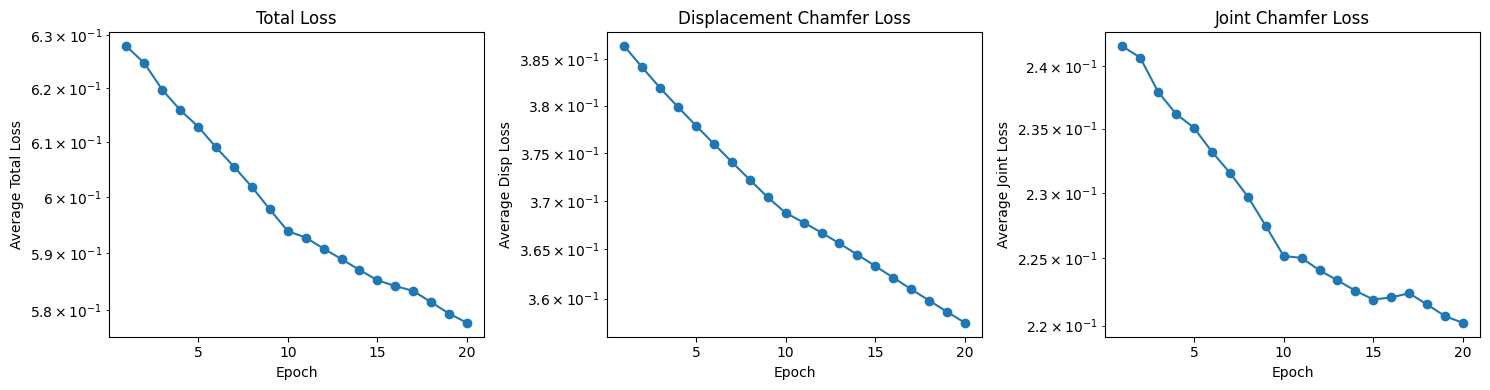

In [46]:
epochs_range = range(1, epochs+1)

# Create a single figure with 3 subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), tight_layout=True)

# Total loss
axes[0].semilogy(epochs_range, total_loss_history, marker='o')
axes[0].set_title("Total Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Average Total Loss")

# Displacement loss
axes[1].semilogy(epochs_range, disp_loss_history, marker='o')
axes[1].set_title("Displacement Chamfer Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Average Disp Loss")

# Joint loss
axes[2].semilogy(epochs_range, joint_loss_history, marker='o')
axes[2].set_title("Joint Chamfer Loss")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Average Joint Loss")

plt.show()

In [ ]:
model.clustering_head.h = 0.067
for batch in dl:
    
    verts = batch['vertices'].detach().clone()
    edges = batch['one_ring'].T.detach()
    vpg = batch['vertices_per_graph']

    vertex_splits = torch.split(torch.arange(verts.size(0)), vpg.tolist())

    joints_pred_list = model(batch)
    joints_gt_list = batch['joints_list']

    all_joints_gt = torch.cat(joints_gt_list).detach().clone()
    joints_gt_counts = [j.size(0) for j in joints_gt_list]
    joint_gt_splits = torch.split(torch.arange(all_joints_gt.size(0)), joints_gt_counts)

    all_joints_pred = torch.cat(joints_pred_list).detach().clone()
    joints_pred_counts = [j.size(0) for j in joints_pred_list]
    joints_pred_splits = torch.split(torch.arange(all_joints_pred.size(0)), joints_pred_counts)

    delta = 0.7
    for i, (v_idxs, j_gt_idxs, j_pred_idxs) in \
        enumerate(zip(vertex_splits, joint_gt_splits, joints_pred_splits)):
        # add z-offset
        verts[v_idxs, 2] += i * delta
        all_joints_gt[j_gt_idxs, 2] += i * delta
        all_joints_pred[j_pred_idxs, 2] += i * delta


    visualize_mesh_graph(
        vertices=verts.numpy(),
        edge_list=edges.numpy(),
        joints_gt=all_joints_gt.detach().numpy(),
        joints_pred=all_joints_pred.detach().numpy()
    )